In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
file_csv = "data/train.csv"
file_json = "data/train.json"

file_csv_test = "data/test.csv"
file_json_test = "data/test.json"

In [3]:
csv_data = pd.read_csv(file_csv, delimiter=',')
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   4000 non-null   int64  
 1   target                    4000 non-null   int64  
 2   name                      3982 non-null   object 
 3   sex                       3616 non-null   object 
 4   dob                       3606 non-null   object 
 5   location                  4000 non-null   object 
 6   location_population       4000 non-null   int64  
 7   location_from             4000 non-null   object 
 8   location_from_population  4000 non-null   int64  
 9   occupation                4000 non-null   object 
 10  hobbies                   3320 non-null   object 
 11  daily_commute             3595 non-null   float64
 12  friends_number            4000 non-null   int64  
 13  relationship_status       3607 non-null   object 
 14  educatio

In [4]:
csv_data.head(10)

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type
0,0,1,Halina,NaN,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,Fitness,46.0,196,Single,NaN,Visa
1,1,0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.0,243,Single,NaN,NaN
2,2,1,Egon,NaN,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.0,191,In relationship,3.0,NaN
3,3,0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,Badminton,88.0,164,In relationship,3.0,Visa
4,4,0,Hilary,NaN,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.0,119,Married with kids,5.0,NaN
5,5,1,Bronisława,NaN,1976-10-09,Ryn,2865,Warszawa,1764615,Street and related sales and service workers,"Rowing,Amateur radio,Sudoku",44.0,204,In relationship,3.0,Mastercard
6,6,0,Agata,female,1981-03-19,Warszawa,1764615,Warszawa,1764615,"Labourers in mining, construction, manufacturi...","Gym,3D printing,Gaming,Flag Football",56.0,117,Married with kids,NaN,Mastercard
7,7,0,Jakub,male,1978-02-24,Dobra,2353,Bielsko-Biała,171505,Administrative and commercial managers,"Crossfit,3D printing,Coloring,Hooping",74.0,224,In relationship,4.0,Visa
8,8,1,Antoni,male,NaN,Gniezno,68943,Gniezno,68943,Personal care workers,"Badminton,Listening to music",9.0,181,In relationship,4.0,Mastercard
9,9,0,Dorota,female,1985-02-17,Warszawa,1764615,Warszawa,1764615,"Market-oriented skilled forestry, fishery and ...",Kettleballs,78.0,187,In relationship,NaN,Visa


In [5]:
""" checking for number of unique values to know if we can use a column as a feature """
csv_data.nunique()

user_id                     4000
target                         2
name                         205
sex                            2
dob                         3242
location                     645
location_population          636
location_from                650
location_from_population     639
occupation                    43
hobbies                     2745
daily_commute                100
friends_number               438
relationship_status            5
education                      6
credit_card_type               4
dtype: int64

In [6]:
""" RN I'll merge train and test data to be preprocessed in the same way (to let hot encoding work properly). Later I'll split it again. """
test_data = pd.read_csv(file_csv_test)

max_id = max(csv_data['user_id'])

test_data['user_id'] = test_data['user_id'].apply(lambda x: x + max_id + 1)
csv_data = pd.concat([csv_data, test_data])
csv_data.set_index('user_id', inplace=True)
csv_data = csv_data.reset_index()
csv_data

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type
0,0,1.0,Halina,NaN,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,Fitness,46.0,196,Single,NaN,Visa
1,1,0.0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.0,243,Single,NaN,NaN
2,2,1.0,Egon,NaN,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.0,191,In relationship,3.0,NaN
3,3,0.0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,Badminton,88.0,164,In relationship,3.0,Visa
4,4,0.0,Hilary,NaN,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.0,119,Married with kids,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5995,NaN,Bohdan,male,1979-11-15,Warszawa,1764615,Starogard Gdański,48060,"Food processing, wood working, garment and oth...","Fitness,Stretching,Kettleballs",98.0,194,In relationship,4.0,Visa
5996,5996,NaN,Arkadiusz,male,2000-01-13,Poznań,538633,Poznań,538633,Street and related sales and service workers,"Weightlifting,Computer programming,Magic",89.0,200,Single,4.0,Visa
5997,5997,NaN,Andrzej,male,1999-04-02,Tarnowskie Góry,61262,Tarnowskie Góry,61262,Drivers and mobile plant operators,"Scrapbooking,Model building,Board games",17.0,270,Married with kids,5.0,Mastercard
5998,5998,NaN,Izabela,NaN,1995-11-06,Wieluń,22794,Wieluń,22794,"Food processing, wood working, garment and oth...","Kettleballs,Gym,Playing musical instruments,Sl...",NaN,202,In relationship,3.0,Visa


In [7]:
""" nan count, doesnt work normally (df.isnull().sum() so I do that in a loop"""
nan_matrix_train = csv_data.iloc[:4000,:].isna()
nan_matrix_test = csv_data.iloc[4000:,:].isna()

"""
we care about:
 'dob',
 'daily_commute'
 'education'
  I'll check later in the model different ways of dealing with missings based on accuracy.
  because the rest is being hot encoded and we assume that no information about interest is being interested in nothing.
"""

for column in csv_data.columns:
    print(f"""nans in {column}:
    train:{nan_matrix_train[column].sum()}, test:{nan_matrix_test[column].sum()}""")



nans in user_id:
    train:0, test:0
nans in target:
    train:0, test:2000
nans in name:
    train:18, test:6
nans in sex:
    train:384, test:191
nans in dob:
    train:394, test:191
nans in location:
    train:0, test:0
nans in location_population:
    train:0, test:0
nans in location_from:
    train:0, test:0
nans in location_from_population:
    train:0, test:0
nans in occupation:
    train:0, test:0
nans in hobbies:
    train:680, test:316
nans in daily_commute:
    train:405, test:204
nans in friends_number:
    train:0, test:0
nans in relationship_status:
    train:393, test:230
nans in education:
    train:408, test:183
nans in credit_card_type:
    train:428, test:205


In [8]:
# TODO: fill the 'sex' column
""" filling missings based on name (there could be some errors if people are not from Poland, but it's minority) """

def sex_filling(row) -> str:
    """ function filling missings in 'sex' column"""
    if pd.notna(row['sex']):
        return row['sex']

    if str(row['name'])[-1] == 'a':
        return 'female'
    else:
        return 'male'

csv_data['sex'] = csv_data.apply(lambda row: sex_filling(row), axis=1)

In [9]:
""" birth date to datetime"""
csv_data['dob'] = pd.to_datetime(csv_data['dob'])

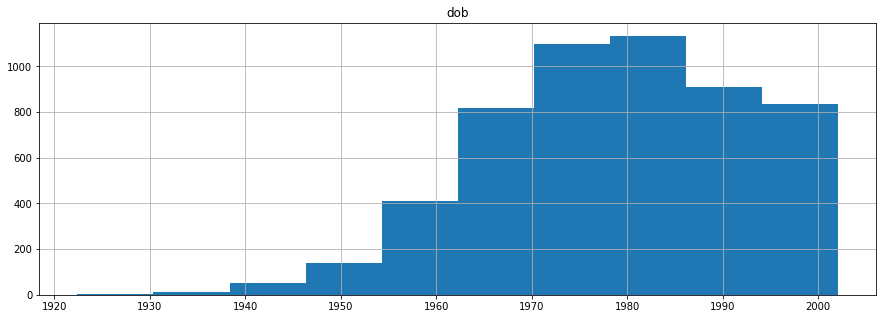

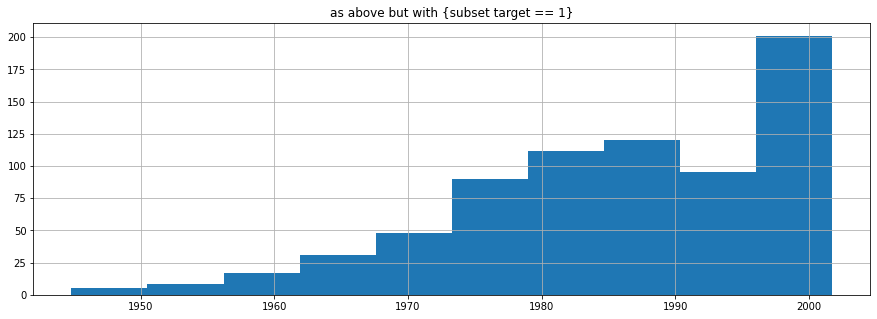

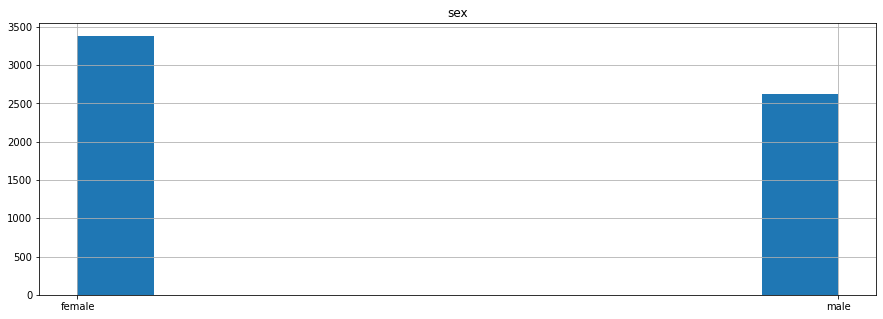

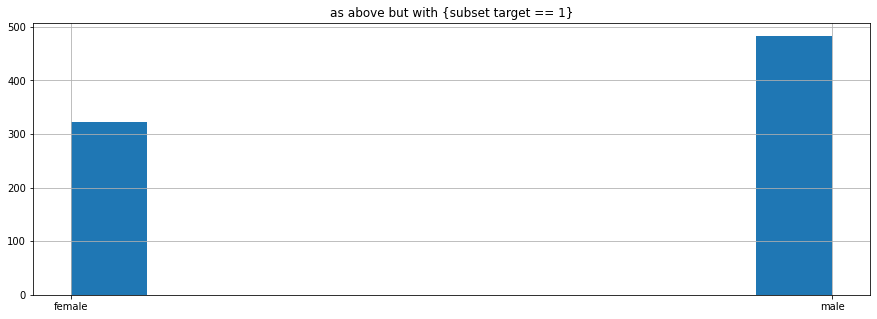

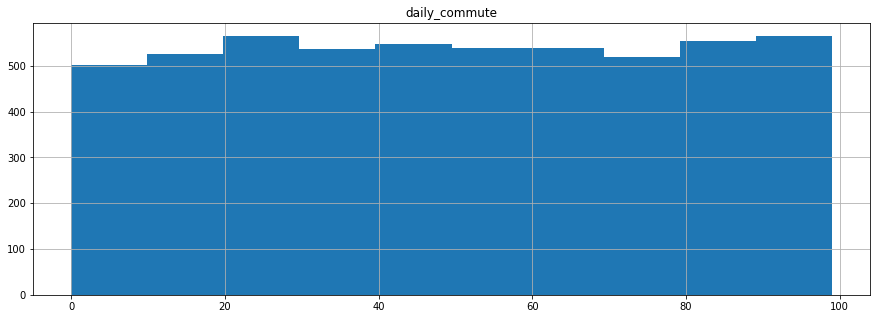

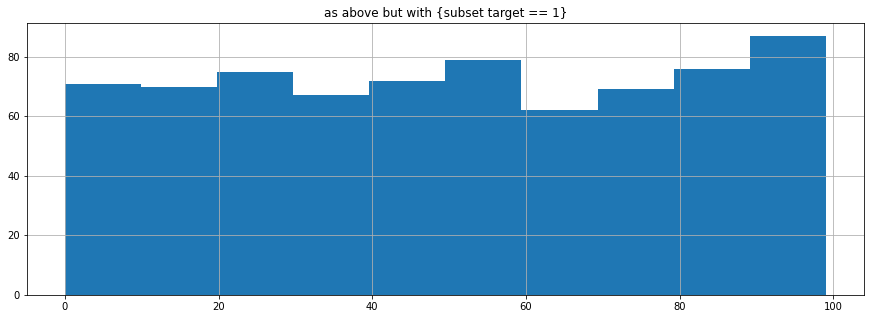

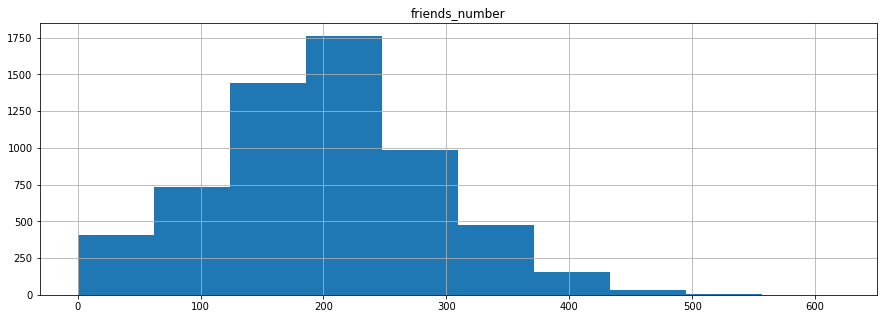

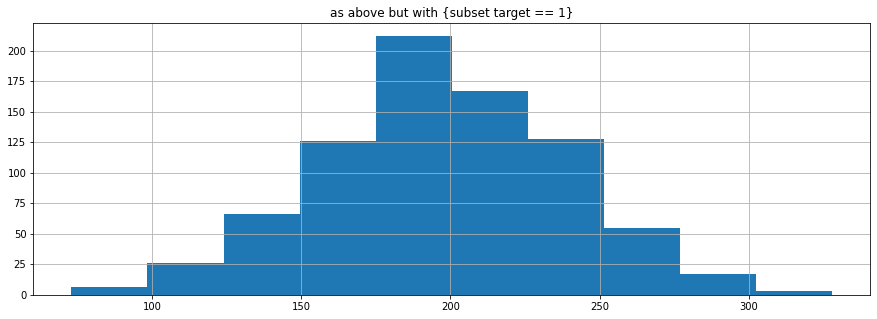

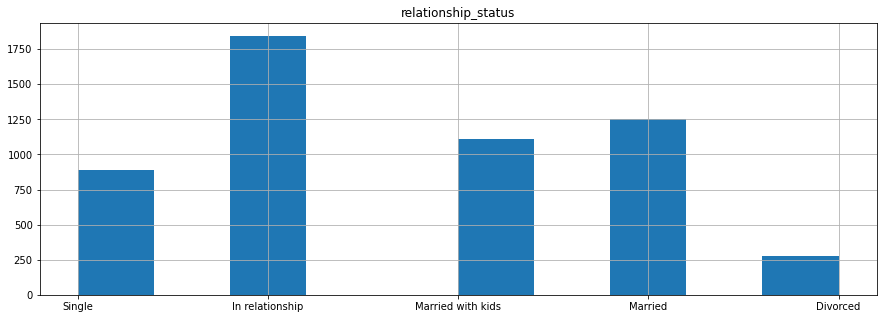

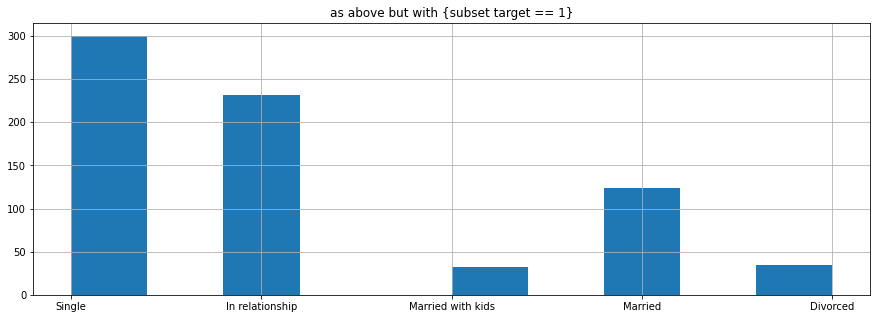

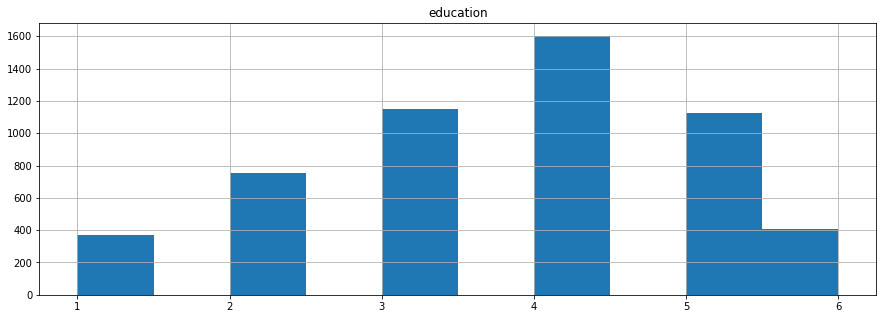

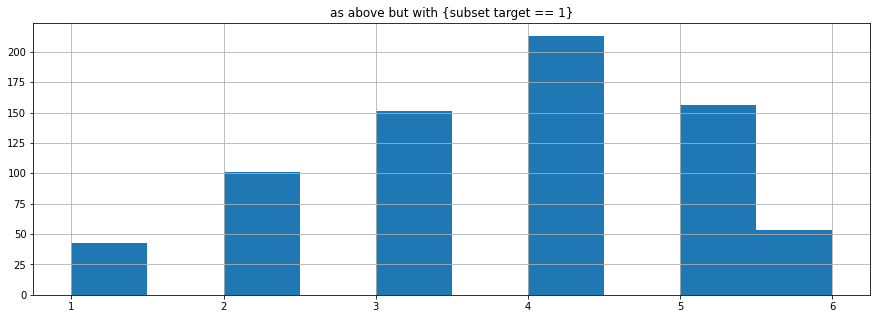

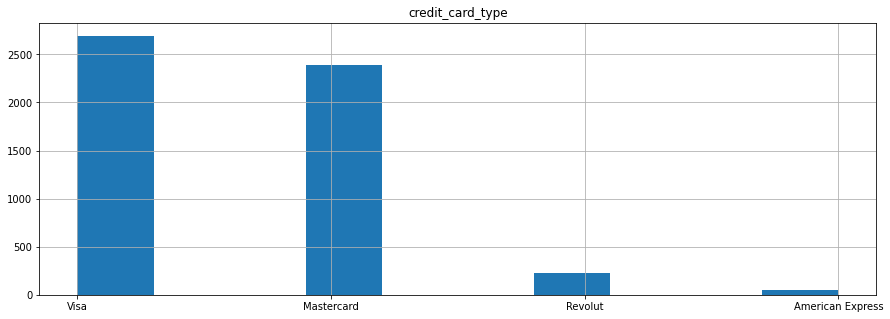

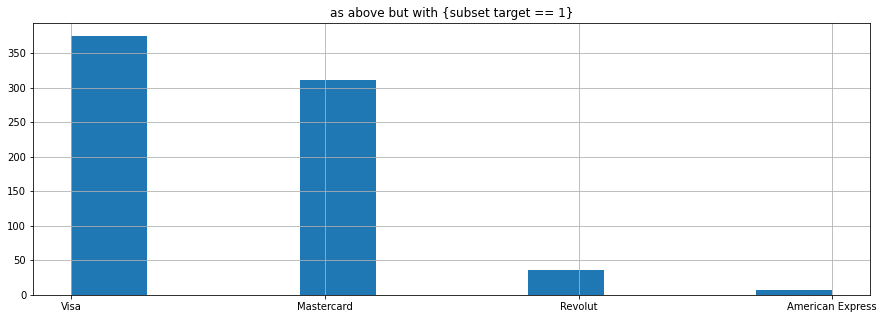

In [10]:
""" preliminary visual analysis to get the intuition about features"""


for column in ['dob', 'sex', 'daily_commute', 'friends_number', 'relationship_status', 'education', 'credit_card_type']:
    plt.figure(figsize=(15,5))
    csv_data[column].hist()
    plt.title(column)
    plt.show()

    plt.figure(figsize=(15,5))
    csv_data.loc[csv_data['target'] == 1, column].hist()
    plt.title('as above but with {subset target == 1}')
    plt.show()

In [11]:
# TODO: split hobbies and add each as a column
""" getting hobbies -> hot encoding"""

# text preprocessing
csv_data['hobbies_list'] = csv_data['hobbies'].apply(lambda x: '['+str(x).lower().replace(' ', '')+']')
csv_data['hobbies_list'] = csv_data['hobbies_list'].replace('[nan]',np.nan)
csv_data['hobbies_list'] = csv_data['hobbies_list'].astype(str)
csv_data['hobbies_list'] = csv_data['hobbies_list'].str.strip('[]').str.split(',')
csv_data['hobbies_list'] = csv_data['hobbies_list'].apply(lambda x: ['hobby_' + it for it in x])

In [12]:
""" hot encoding hobbies"""
mlb = MultiLabelBinarizer()
csv_data = csv_data.join(pd.DataFrame(mlb.fit_transform(csv_data.pop('hobbies_list')),
                          columns=mlb.classes_,
                          index=csv_data.index))
csv_data.drop(columns=['hobby_nan'], inplace= True)
csv_data.head(5)

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,...,hobby_watersports,hobby_websurfing,hobby_weightlifting,hobby_whittling,hobby_woodcarving,hobby_woodworking,hobby_worldbuilding,hobby_writing,hobby_yo-yoing,hobby_yoga
0,0,1.0,Halina,female,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,...,0,0,0,0,0,0,0,0,0,0
2,2,1.0,Egon,male,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,...,0,0,0,0,0,0,0,0,0,0
3,3,0.0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,...,0,0,0,0,0,0,0,0,0,0
4,4,0.0,Hilary,male,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# TODO: get age from birth_date
""" creating 'age' [days] feature. age is shifted so the youngest person in dataset has age = 0 days"""
csv_data['age'] = max(csv_data['dob']) - csv_data['dob']
csv_data['age'] = csv_data['age'].dt.days
csv_data['age'].head(10)

0     7121.0
1    11057.0
2      579.0
3     3526.0
4     9888.0
5     9249.0
6     7627.0
7     8746.0
8        NaN
9     6196.0
Name: age, dtype: float64

In [14]:
# TODO: use label encoder for string data
""" hot encoding data; we use 'df' variable from now on """

# 1. sex;
df = pd.merge(csv_data,pd.get_dummies(csv_data.sex, prefix='sex'), left_on='user_id', right_index=True, how='left')

# 2. location
df = pd.merge(df,pd.get_dummies(csv_data.location, prefix='location'), left_on='user_id', right_index=True, how='left')

# 3. location_from
df = pd.merge(df,pd.get_dummies(csv_data.location_from, prefix='location_from'), left_on='user_id', right_index=True, how='left')

# 4. occupation
csv_data['occupation'] = csv_data['occupation'].apply(lambda x: str(x).lower().replace(" ","").replace(",","").replace("-",""))
df = pd.merge(df,pd.get_dummies(csv_data.occupation, prefix='occupation'), left_on='user_id', right_index=True, how='left')

# relationship status
csv_data['relationship_status'] = csv_data['relationship_status'].apply(lambda x: str(x).lower().replace(" ","").replace(",","").replace("-",""))
df = pd.merge(df,pd.get_dummies(csv_data.relationship_status, prefix='relationship'), left_on='user_id', right_index=True, how='left')

# credit_card
df = pd.merge(df,pd.get_dummies(csv_data.credit_card_type, prefix='card'), left_on='user_id', right_index=True, how='left')

df.tail()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,...,relationship_divorced,relationship_inrelationship,relationship_married,relationship_marriedwithkids,relationship_nan,relationship_single,card_American Express,card_Mastercard,card_Revolut,card_Visa
5995,5995,NaN,Bohdan,male,1979-11-15,Warszawa,1764615,Starogard Gdański,48060,"Food processing, wood working, garment and oth...",...,0,1,0,0,0,0,0,0,0,1
5996,5996,NaN,Arkadiusz,male,2000-01-13,Poznań,538633,Poznań,538633,Street and related sales and service workers,...,0,0,0,0,0,1,0,0,0,1
5997,5997,NaN,Andrzej,male,1999-04-02,Tarnowskie Góry,61262,Tarnowskie Góry,61262,Drivers and mobile plant operators,...,0,0,0,1,0,0,0,1,0,0
5998,5998,NaN,Izabela,female,1995-11-06,Wieluń,22794,Wieluń,22794,"Food processing, wood working, garment and oth...",...,0,1,0,0,0,0,0,0,0,1
5999,5999,NaN,Emanuela,female,1982-10-25,Zabrze,174349,Zabrze,174349,"Agricultural, forestry and fishery labourers",...,0,0,0,1,0,0,0,1,0,0


In [15]:
# TODO: data normalization
""" normalizing data.
For now i'm taking min-max normalization. In future I could try also mean normalization"""
def min_max_normalizer(row):
    min_val = np.min(row)
    max_val = np.max(row)
    return (row - min_val) / (max_val - min_val)

for column in ['location_population', 'location_from_population', 'age', 'daily_commute', 'friends_number', 'education']:
    df[column] = min_max_normalizer(df[column])


In [16]:
"""removing rest of not relevant columns"""
# 'nan' column from hotencoding:
df.drop(columns=['relationship_nan'], inplace=True)
# others
df.drop(columns=['name','sex','dob','location','location_from','occupation','hobbies','relationship_status','credit_card_type'], inplace=True)

In [17]:
# TODO: make use of json table
""" getting dataframe from json file """
file = open(file_json, encoding='utf-8')
data = json.load(file)


# SOURCE: https://stackoverflow.com/questions/68454773/how-to-create-pandas-dataframe-from-nested-json-with-dictionary
d = {}
for group in data["data"]:
    groups = [x["group_name"] for x in group['groups']["data"]]
    d['id'] = d.get('id', []) + [group['id']] * len(groups)
    d['group'] = d.get('group', []) + groups
    d['date_joined'] = d.get('date_joined', []) + [x["date_joined"] for x in group['groups']["data"]]

json_data = pd.DataFrame(d)
json_data.head(10)

,id,group,date_joined
0,0,Let's excercise together and lose a few kilo q...,2008-09-05 09:55:18.730066
1,0,Strongman competition,2008-05-22 21:25:22.572365
2,0,Fast food 4 life,2012-02-02 05:26:01.293628
3,0,alternative medicine - Hypnosis and bioenergot...,2008-07-05 05:47:12.254848
4,1,Tom Cruise group,2009-06-14 16:48:28.606142
5,1,Babysitters (Sokółka),2010-09-25 03:21:01.944684
6,1,Work abroad - join to find well paid work and ...,2010-09-21 23:44:39.499240
7,1,"Tennis, Squash, Badminton, table tennis - look...",2007-10-09 17:15:13.896508
8,1,Lost&Found (Sokółka),2007-01-03 04:49:01.499555
9,2,Polish wildlife - best places,2007-07-29 18:15:49.603727


In [18]:
""" as we can see, there is 4207 unique groups which is quite a lot. What I'd do there (but i won't because i don't really have time for that :C ) is:
 1. text processing:
 1a. get stopwords out
 1b. get key words using `yake` or smth.
 2. create binary matrix for each word and append it to the user table as a feature.
 3. if there would be a need for making the model better, I'd do it using some Open Source tool or hire some people to mark some of the words as connected with sports.
 4. if there would be a need for making the model better, I'd consider making usage of correlation matrix between users (smth like collaborative filtering in the Recommender systems.) """
json_data.nunique()

id              3944
group           4207
date_joined    16118
dtype: int64

In [19]:
""" saving preprocessed data """

with open('data/temp_data/csv_data_preprocessed.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)